[1,   100] loss: 0.392
[1,   200] loss: 0.342
[1,   300] loss: 0.321
[1,   400] loss: 0.308
[1,   500] loss: 0.298
[1,   600] loss: 0.284
[1,   700] loss: 0.277
[1,   800] loss: 0.266
[1,   900] loss: 0.264
[1,  1000] loss: 0.264
[1,  1100] loss: 0.258
[1,  1200] loss: 0.249
[1,  1300] loss: 0.246
[1,  1400] loss: 0.231
[1,  1500] loss: 0.221
[2,   100] loss: 0.218
[2,   200] loss: 0.208
[2,   300] loss: 0.212
[2,   400] loss: 0.212
[2,   500] loss: 0.157
[2,   600] loss: 0.149
[2,   700] loss: 0.143
[2,   800] loss: 0.132
[2,   900] loss: 0.129
[2,  1000] loss: 0.124
[2,  1100] loss: 0.117
[2,  1200] loss: 0.121
[2,  1300] loss: 0.115
[2,  1400] loss: 0.119
[2,  1500] loss: 0.111
[3,   100] loss: 0.108
[3,   200] loss: 0.102
[3,   300] loss: 0.106
[3,   400] loss: 0.100
[3,   500] loss: 0.100
[3,   600] loss: 0.099
[3,   700] loss: 0.092
[3,   800] loss: 0.097
[3,   900] loss: 0.092
[3,  1000] loss: 0.096
[3,  1100] loss: 0.089
[3,  1200] loss: 0.089
[3,  1300] loss: 0.092
[3,  1400] 

[24,   300] loss: 0.070
[24,   400] loss: 0.063
[24,   500] loss: 0.060
[24,   600] loss: 0.060
[24,   700] loss: 0.063
[24,   800] loss: 0.054
[24,   900] loss: 0.065
[24,  1000] loss: 0.064
[24,  1100] loss: 0.065
[24,  1200] loss: 0.065
[24,  1300] loss: 0.067
[24,  1400] loss: 0.059
[24,  1500] loss: 0.062
[25,   100] loss: 0.060
[25,   200] loss: 0.063
[25,   300] loss: 0.064
[25,   400] loss: 0.062
[25,   500] loss: 0.061
[25,   600] loss: 0.063
[25,   700] loss: 0.064
[25,   800] loss: 0.065
[25,   900] loss: 0.063
[25,  1000] loss: 0.064
[25,  1100] loss: 0.052
[25,  1200] loss: 0.065
[25,  1300] loss: 0.062
[25,  1400] loss: 0.066
[25,  1500] loss: 0.059
[26,   100] loss: 0.059
[26,   200] loss: 0.063
[26,   300] loss: 0.061
[26,   400] loss: 0.057
[26,   500] loss: 0.060
[26,   600] loss: 0.063
[26,   700] loss: 0.061
[26,   800] loss: 0.059
[26,   900] loss: 0.063
[26,  1000] loss: 0.061
[26,  1100] loss: 0.064
[26,  1200] loss: 0.062
[26,  1300] loss: 0.065
[26,  1400] loss

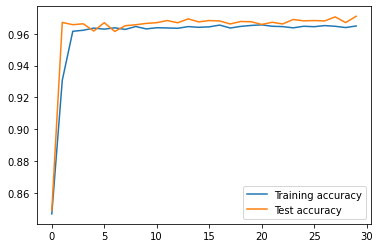

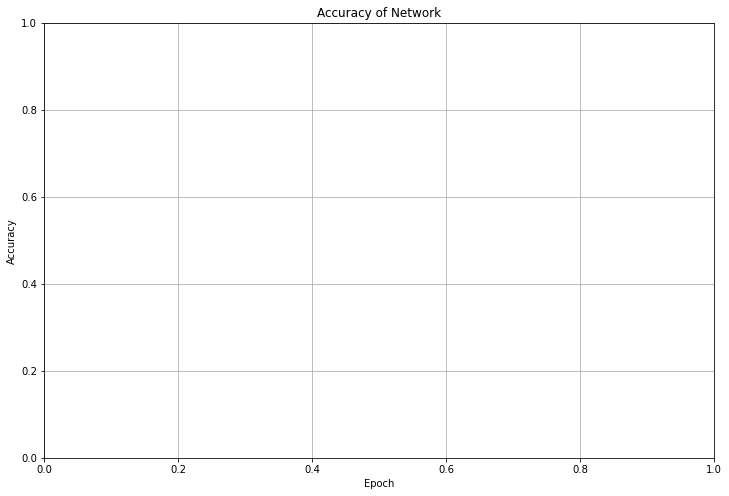

Accuracy of the network on the test point clouds: 96 %


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 27 09:40:41 2021

@author: Johanna

pointnet from https://github.com/myx666/pointnet-in-pytorch/blob/master/pointnet.pytorch/dataset.py
"""

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

import sys 
sys.path.insert(0, './Onedrive/Project-T2/PointNetJJ')
from spheres_JJ import sphere_generator

class PointNetCls(nn.Module):
    def __init__(self, k=16):
        super(PointNetCls, self).__init__()
        self.conv1 = torch.nn.Conv1d(npoints, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(k)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        x = F.relu(self.bn6(self.dropout(x)))
        return F.log_softmax(x, dim=1)
   
###########################################################    
# Training
nclouds = 50000
npoints = 100

# The point clouds
normal = torch.randn(nclouds, npoints, 1)
means = torch.rand(nclouds) 
covs = torch.rand(nclouds)* 0.05

for i in range(nclouds):
    normal[i, :, 0] = normal[i, :, 0]*covs[i] + means[i]
    normal[i, :, 0] %= 1
uniform = torch.rand(nclouds, npoints, 1)
trainset = torch.cat((normal, uniform))

# Labels
zeros = torch.zeros(nclouds, dtype=torch.long)
ones = torch.ones(nclouds, dtype=torch.long)
labels = torch.cat((zeros, ones))

dataset = TensorDataset(trainset, labels)
# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                          shuffle=True, num_workers=2, drop_last=True)

#########################################################
# Testing clouds

ncloudstest = 10000
npointstest = 100

# The point clouds
means = torch.rand(ncloudstest)
covs = torch.rand(ncloudstest)* 0.05
normaltest = torch.randn(ncloudstest, npointstest, 1)
for i in range(ncloudstest):
    normaltest[i, :, 0] = normal[i, :, 0]*covs[i] + means[i]
    normaltest[i, :, 0] %= 1
uniformtest = torch.rand(ncloudstest, npointstest, 1)
testset = torch.cat((normaltest, uniformtest))
test = testset

# Labels
testzeros = torch.zeros(ncloudstest, dtype=torch.long)
testones = torch.ones(ncloudstest, dtype=torch.long)
testlabels = torch.cat((testzeros, testones))
#print(labels.view(-1,2).size())


testset = TensorDataset(testset, testlabels)
# Creating the batches
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=True, num_workers=2, drop_last=True)

############################################################

net = PointNetCls(k=2)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

nepochs = 30

train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)
train_loss = np.zeros(nepochs)
test_loss = np.zeros(nepochs)
for epoch in range(nepochs):  # loop over the dataset multiple times
    epoch_train_acc = 0.0
    running_loss = 0.0
    epoch_train_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        _, train_predicted = torch.max(outputs.data, 1)
        epoch_train_acc += (train_predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        epoch_train_loss += loss.item()
        if i % 100 == 99:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        counter += 1
    
    epoch_test_loss = 0.0
    epoch_test_acc = 0.0
    counter2 = 0
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        _, test_predicted = torch.max(outputs.data, 1)
        epoch_test_acc += (test_predicted == labels).sum().item()
        epoch_test_loss += loss.item()
        counter2 += 1

            
    
    train_acc[epoch] = epoch_train_acc/nclouds/2
    test_acc[epoch] = epoch_test_acc/ncloudstest/2
    train_loss[epoch] = epoch_train_loss/counter
    test_loss[epoch] = epoch_test_loss/counter2
    epoch_train_loss = 0.0

print('Finished Training')

x = np.arange(nepochs)
plt.plot(x, train_acc, label='Training accuracy')
plt.plot(x, test_acc, label='Test accuracy')
plt.legend()
plt.figure(figsize=(12,8))
plt.title('Accuracy of Network')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test point clouds: %d %%' % (
    100 * correct / total))

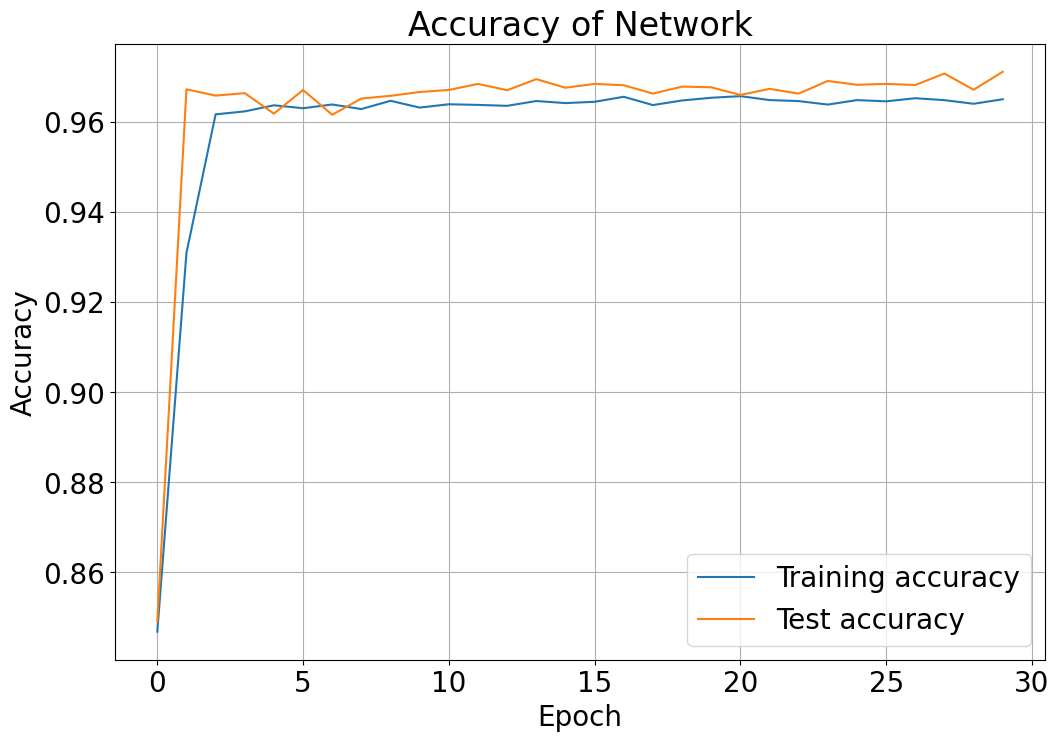

Accuracy of the network on the test point clouds: 96 %


In [14]:
x = np.arange(nepochs)
plt.figure(figsize=(12,8))
font = {'size'   : 20}
plt.rc('font', **font)
plt.plot(x, train_acc, label='Training accuracy')
plt.plot(x, test_acc, label='Test accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy of Network')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('Accuracy1DJJ.jpeg', bbox_inches ='tight')
plt.show()

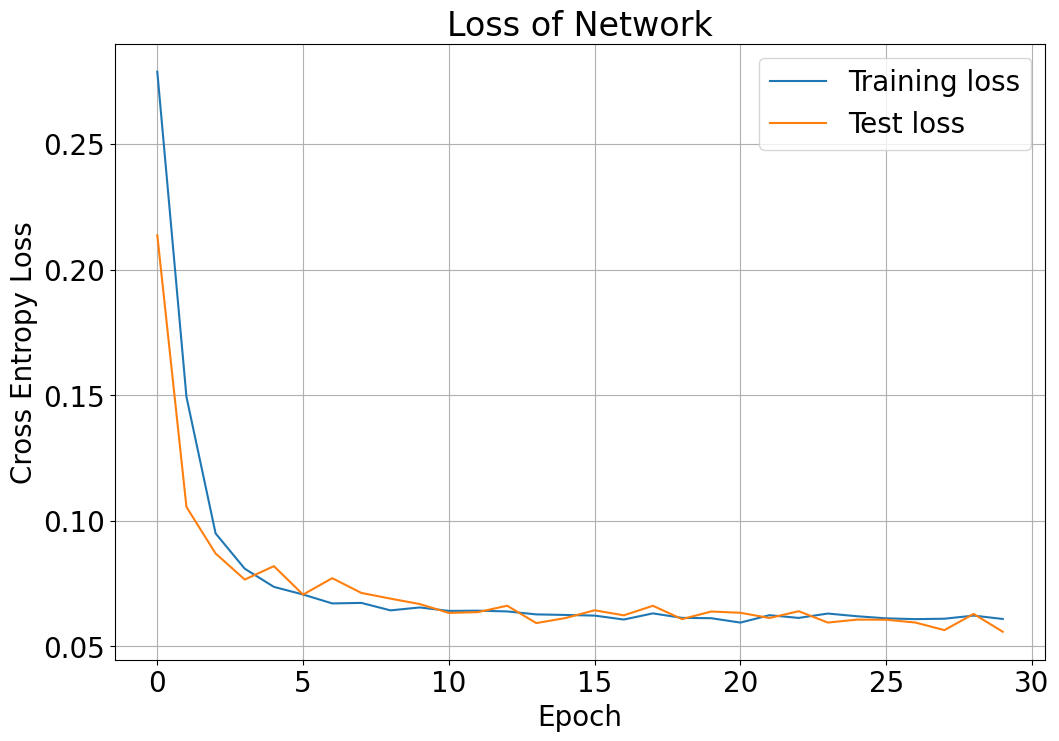

In [15]:
x = np.arange(nepochs)
plt.figure(figsize=(12,8))
plt.rc('font', **font)
plt.plot(x, train_loss, label='Training loss')
plt.plot(x, test_loss, label='Test loss')
plt.legend()
plt.grid()
plt.title('Loss of Network')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.savefig('Loss1D.jpeg', bbox_inches ='tight')
plt.show()

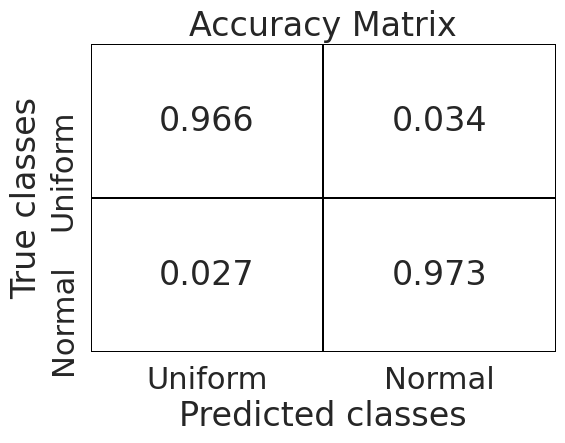

In [18]:
# Confusion matrix

import sklearn
import seaborn as sn
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# classes
classes = ('Uniform', 'Normal')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
#cf_matrix = cf_matrix/100
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 2, index = [i for i in classes],
                     columns = [i for i in classes])

# plot
sn.set(font_scale=2)
plt.figure(figsize = (6,4))
sn.heatmap(df_cm, annot=True,cbar=False,linewidths=1,linecolor='black', cmap=ListedColormap(['white']),
                      fmt = ".3f")
plt.xlabel('Predicted classes')
plt.ylabel('True classes') 
plt.title('Accuracy Matrix')
plt.savefig('Confusionmatrix1Dbw.jpeg', bbox_inches ='tight')
plt.show()